In [1]:
import os

if not os.path.exists('/content/police-records-project'):
    !git clone https://github.com/c-goenka/police-records-project.git
    %cd /content/police-records-project
    !pip install -r requirements.txt
else:
    %cd /content/police-records-project

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'police-records-project'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 120 (delta 61), reused 99 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 105.71 KiB | 21.14 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/police-records-project
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from setfit import SetFitModel, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
data_dir = "/content/drive/MyDrive/police-records-project-data/processed"

train_df = pd.read_csv(f"{data_dir}/train.csv")
test_df = pd.read_csv(f"{data_dir}/test.csv")

print(f"Train: {len(train_df)} documents")
print(f"Test: {len(test_df)} documents\n")
print(f"Classes: {train_df['label'].nunique()}")
print(f"Labels: {sorted(train_df['label'].unique())}")

Train: 75 documents
Test: 23 documents

Classes: 11
Labels: ['discovery-package', 'emails-memorandum-correspondence', 'police-commision-agenda', 'press-release', 'reports-coroners', 'reports-criminal', 'reports-death-in-custody', 'reports-incident', 'reports-investigation', 'reports-supplemental', 'reports-use-of-force']


In [4]:
label_to_id = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

train_df['label_id'] = train_df['label'].map(label_to_id)
test_df['label_id'] = test_df['label'].map(label_to_id)

train_dataset = Dataset.from_dict({
    'text': train_df['text_clean'].tolist(),
    'label': train_df['label_id'].tolist()
})

test_dataset = Dataset.from_dict({
    'text': test_df['text_clean'].tolist(),
    'label': test_df['label_id'].tolist()
})

print(f"Label mapping:")
for label, idx in sorted(label_to_id.items(), key=lambda x: x[1]):
    print(f"  {idx}: {label}")

Label mapping:
  0: discovery-package
  1: emails-memorandum-correspondence
  2: police-commision-agenda
  3: press-release
  4: reports-coroners
  5: reports-criminal
  6: reports-death-in-custody
  7: reports-incident
  8: reports-investigation
  9: reports-supplemental
  10: reports-use-of-force


In [5]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model = SetFitModel.from_pretrained(
    model_name,
    labels=list(label_to_id.keys())
)

print(f"Model loaded: {model_name}")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Model loaded: sentence-transformers/all-mpnet-base-v2


In [6]:
args = TrainingArguments(
    batch_size=16,
    num_epochs=1,
    eval_strategy="no",
    save_strategy="no",
    seed=RANDOM_SEED
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset
)

trainer.train()
print("SetFit Model Training complete")

Map:   0%|          | 0/75 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4626
  Batch size = 16
  Num epochs = 1
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cgoenka (cgoenka-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
1,0.214100
50,0.154900
100,0.031400
150,0.005300
200,0.003000
250,0.001100


SetFit Model Training complete


In [7]:
predictions = model.predict(test_df['text_clean'].tolist())
y_true = test_df['label_id'].values
y_pred = [label_to_id[label] for label in predictions]

In [8]:
results_df = pd.DataFrame({
    'text': test_df['text_clean'],
    'true_label': test_df['label'],
    'pred_label': [id_to_label[i] for i in y_pred],
    'correct': y_true == y_pred
})

output_path = "/content/drive/MyDrive/police-records-project-data/processed/setfit_results.csv"
results_df.to_csv(output_path, index=False)

print(f"Saved results to: {output_path}")

Saved results to: /content/drive/MyDrive/police-records-project-data/processed/setfit_results.csv


In [9]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
accuracy = (y_true == y_pred).mean()

print(f"Macro F1: {macro_f1:.4f}")
print(f"Accuracy: {accuracy:.4f} ({(y_true == y_pred).sum()}/{len(y_true)})")
print(f"Correct predictions: {(y_true == y_pred).sum()}/{len(y_true)}")

Macro F1: 0.6555
Accuracy: 0.7826 (18/23)
Correct predictions: 18/23


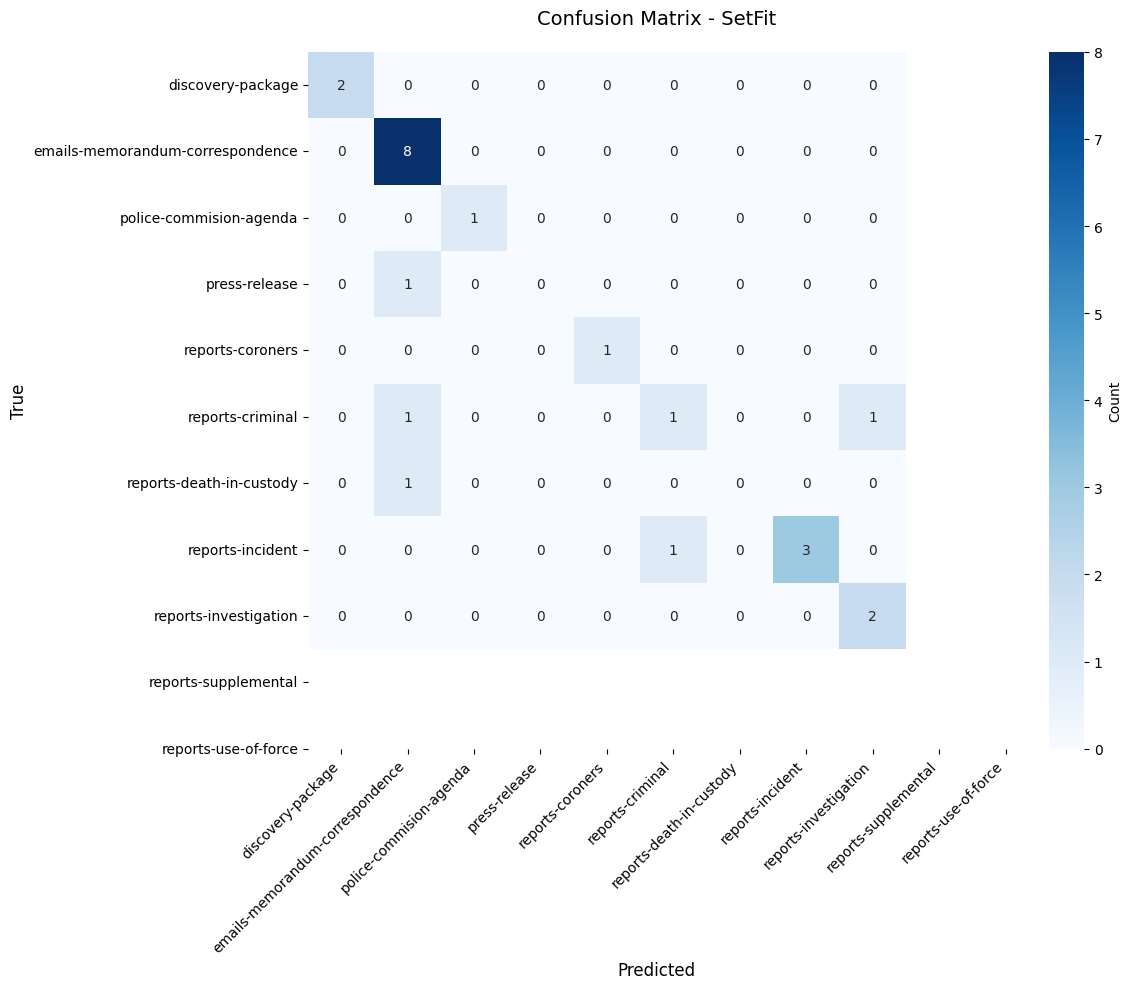

In [10]:
cm = confusion_matrix(y_true, y_pred)
labels = [id_to_label[i] for i in sorted(id_to_label.keys())]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - SetFit', fontsize=14, pad=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()
plt.show()